# UNSUPERVISED BOUNDING BOXES FOR BINARY IMAGES

## Importing the images
The inpute are binary images:

+ black = background
+ white = anomalies

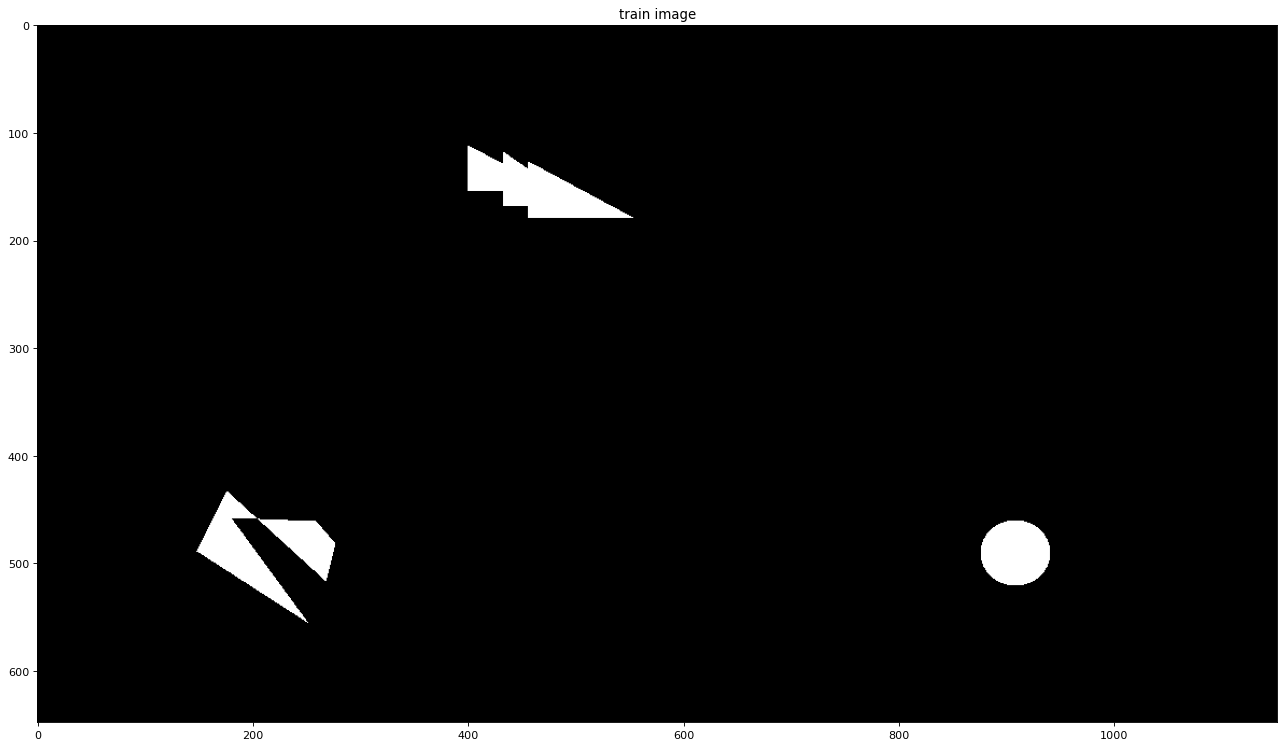

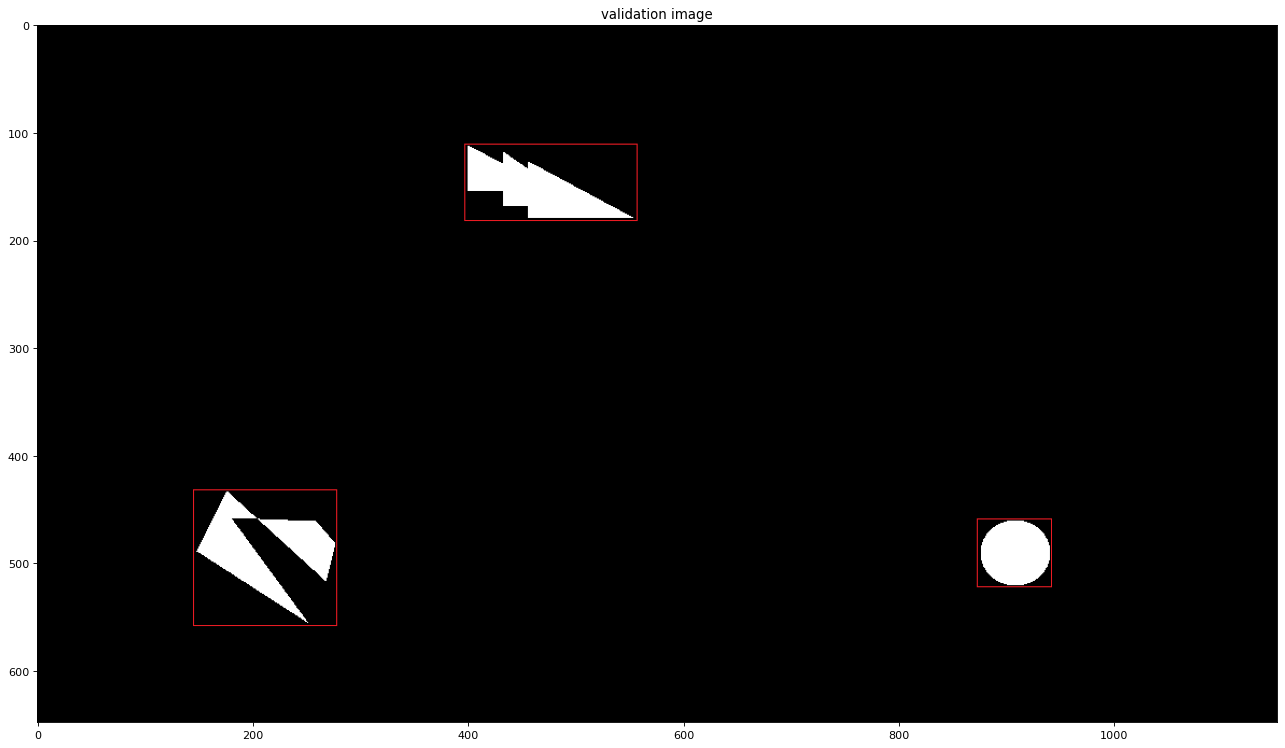

In [166]:
import matplotlib.pyplot as plt
import cv2
# import matplotlib.image as mpimg

# UPLOAD A RANDOM PICTURE
img_train_path = "train_binary_image.png"
img_val_path = "validation_binary_image.png"

# Display the images
img_train = cv2.imread(img_train_path)
img_val = cv2.imread(img_val_path)

rgb_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
rgb_val = cv2.cvtColor(img_val, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(rgb_train)
plt.title('train image')
plt.show()

plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(rgb_val)
plt.title('validation image')
plt.show()

## Object detection + Bounding box 

Box features: [(877, 461, 64, 60), (205, 459, 72, 58), (148, 434, 104, 122), (400, 113, 154, 67)]


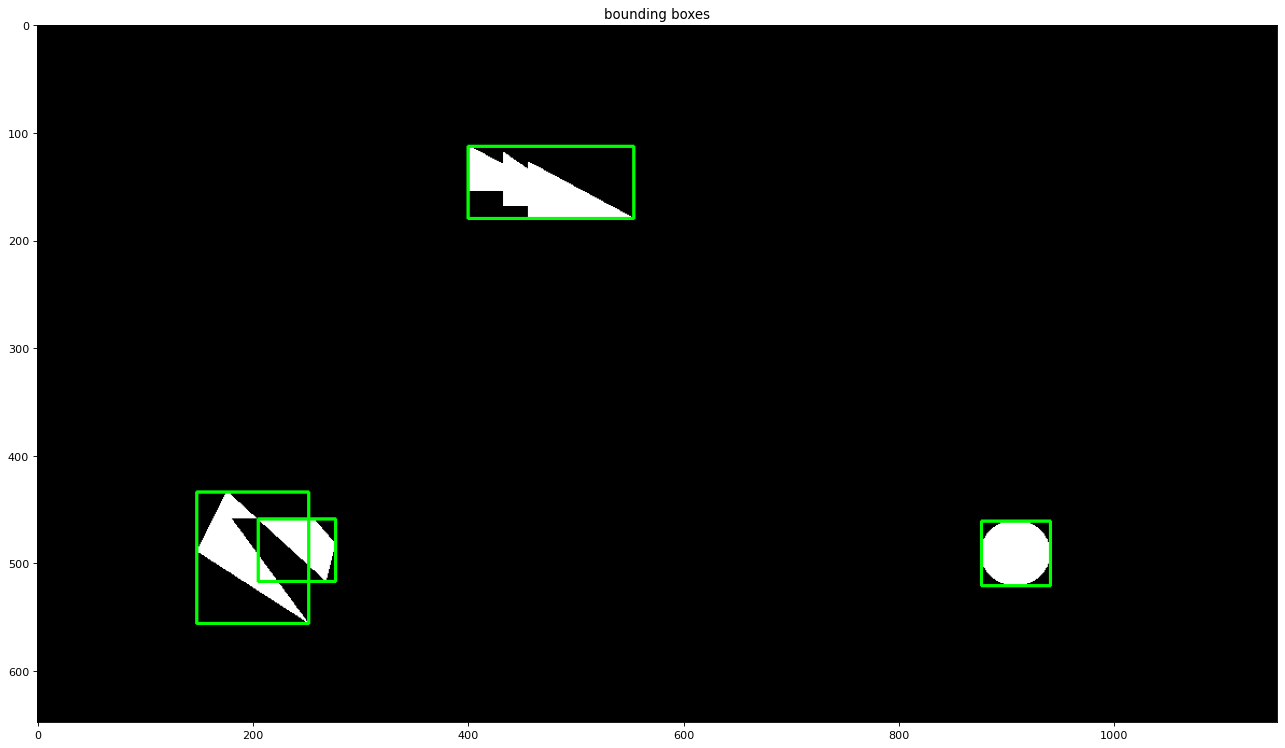

In [167]:
## drawing b.box for given coutour

img = cv2.imread(img_train_path)
# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
result = img.copy()
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
boxes = []
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    boxes.append((x,y,w,h))
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
#     print("x,y,w,h:",x,y,w,h)
 
print('Box features:', boxes)
  

rgb_train_box =  cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(rgb_train_box)
plt.title('bounding boxes')
plt.show()


### Obtaining validation bounding boxes

In [168]:
# Obtain testing bounding boxes, by mouse clicking.

#This variable we use to store the pixel location
refPt = []
def click_event(event, x, y, flags, params):
    '''
    Left Click to get the x, y coordinates.
    Right Click to get BGR color scheme at that position.
    '''
    text = ''
    font = cv2.FONT_HERSHEY_COMPLEX
    color = (255, 0, 0)
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt.append([x,y])
        print(x, ",", y)
        text = str(x) + "," + str(y)
        color = (0, 255, 0)
    elif event == cv2.EVENT_RBUTTONDOWN:
        refPt.append([x,y])
        b = img[y, x, 0]
        g = img[y, x, 1]
        r = img[y, x, 2]
        text = str(b) + ',' + str(g) + ',' + str(r)
        color = (0, 0, 255)
    cv2.putText(img_val, text, (x, y), font, 0.5, color, 1, cv2.LINE_AA)
    cv2.imshow('Click upper-lef/right-bottom corner of boxes', img_val)
    
img_val = cv2.imread(img_val_path) # Opening again for not writing in the original picture
cv2.imshow("Click upper-lef/right-bottom corner of boxes", img_val)

#calling the mouse click event
cv2.setMouseCallback("Click upper-lef/right-bottom corner of boxes", click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

145 , 432
278 , 559
398 , 111
558 , 181
873 , 460
943 , 523


In [169]:
print('Check for storing:',refPt)
box_val  = []
for i in range(0,len(refPt),2):
    x1, y1 = refPt[i]
    x2, y2 = refPt[i+1]
    box_val.append((x1, y1, x2, y2))
print('Validation bounding boxes:', box_val)


Check for storing: [[145, 432], [278, 559], [398, 111], [558, 181], [873, 460], [943, 523]]
Validation bounding boxes: [(145, 432, 278, 559), (398, 111, 558, 181), (873, 460, 943, 523)]


## Validation of bounding boxes


Bounding boxes: [(845.0, 431.0, 909.0, 491.0), (169.0, 430.0, 241.0, 488.0), (96.0, 373.0, 200.0, 495.0), (323.0, 79.5, 477.0, 146.5)]


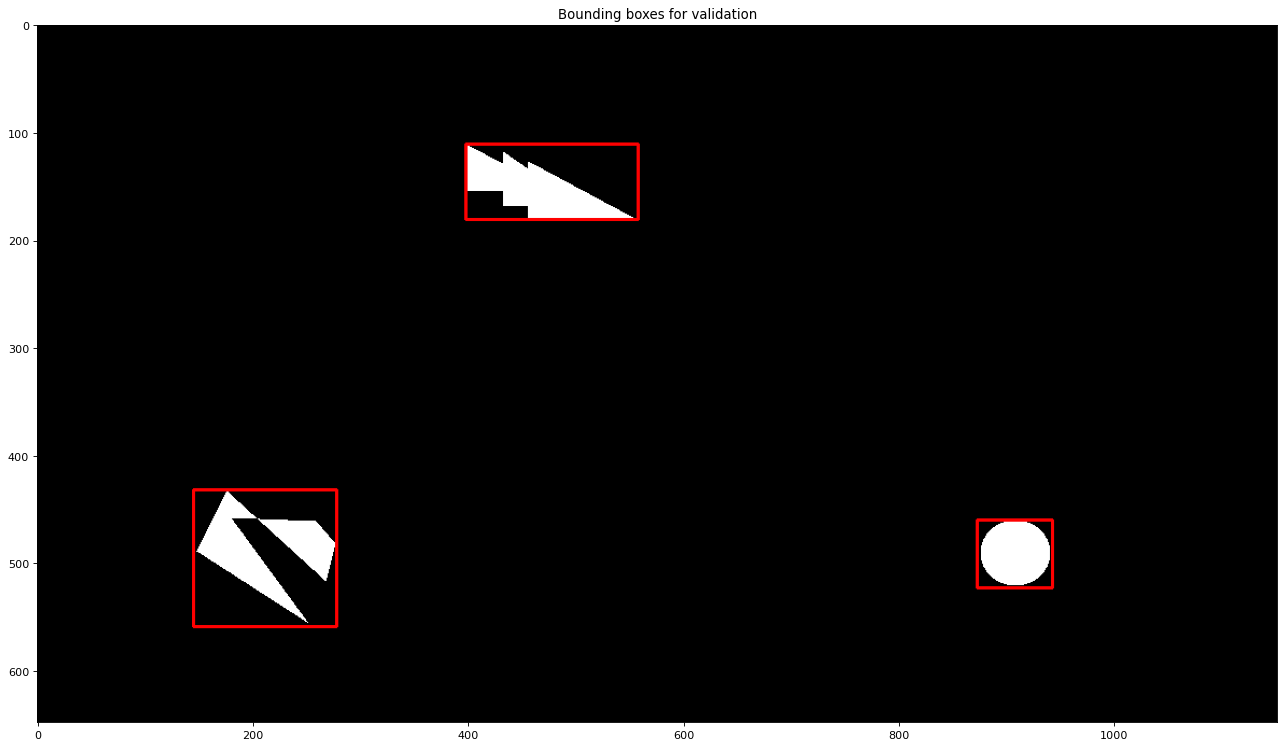

In [170]:
# First convert box parameters from (x,y,w,h) [YOLO FORMAT] to (x1,y1,x2,y2) [BOUNDING BOX FORMAT], where (x1,y1) are for the upper-left corner and 
# (x2,y2) are for the bottom-right corner.
def yolobbox2bbox(x,y,w,h):
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2

b2b = []
for box in boxes:
    x,y,w,h = box
    b2b.append(yolobbox2bbox(x,y,w,h))
print('Bounding boxes:', b2b)

# Draw clicked boxes
img_train_box = img_train.copy()
for box in box_val:
    x1, y1, x2, y2 = box
    cv2.rectangle(img_train_box, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

rgb_val_box =  cv2.cvtColor(img_train_box, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(rgb_val_box)
plt.title('Bounding boxes for validation')
plt.show()

In [171]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : tuple
        Tuple: (x1, y1, x2, y2)
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : tuple
        Tuple: (x1, y1, x2, y2)
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

In [172]:
# Compare each b2b with each box_val, the one with the highest IoU score is the one who correponds to the given b2b.
iou_result = []
for box in b2b:
    
    iou = 0
    for box_v in box_val:
        iou_v = get_iou(box_v, box)
        iou = max(iou, iou_v)
    print('Box:', box, 'IoU:', iou)
    iou_result.append(iou)

Box: (845.0, 431.0, 909.0, 491.0) IoU: 0.1564339781328848
Box: (169.0, 430.0, 241.0, 488.0) IoU: 0.23668916935720574
Box: (96.0, 373.0, 200.0, 495.0) IoU: 0.13268744734625104
Box: (323.0, 79.5, 477.0, 146.5) IoU: 0.14986507067090604


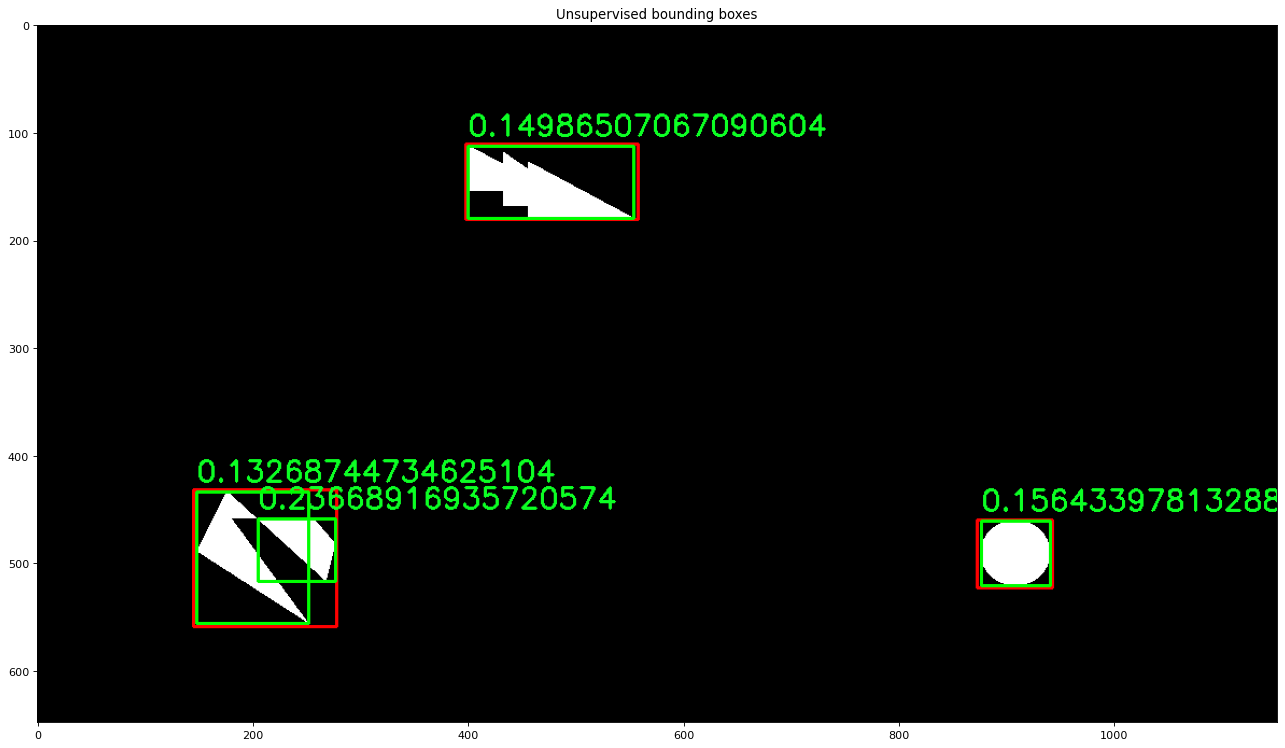

In [173]:
# Draw the all boxes an their respective IoU value

result_final = img_train_box.copy()
for box, iou in zip(boxes, iou_result):
    x,y,w,h = box
    cv2.rectangle(result_final, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(result_final, str(iou), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    
rgb_final =  cv2.cvtColor(result_final, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(rgb_final)
plt.title('Unsupervised bounding boxes')
plt.show()

 <font color='red'>I am getting low values in IoU! I need to check it again!</font>